<a href="https://colab.research.google.com/github/ChenyueZhao97/Metaphor-Processing-in-LLM/blob/main/LLM_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
save_dir = '/content/drive/MyDrive/ColabNotebooks'

In [3]:
%%capture
# The above line prevents output from being displayed for the current cell.
# Installing packages produces a lot of output, and we don't care about it.

!pip3 install matplotlib seaborn
!pip3 install nltk pandas
!pip3 install pytorch pytorch-cuda torchaudio torchvision
!pip3 install transformers accelerate

In [4]:
import pandas as pd

In [5]:
import torch

# CausalLM = "Causal Language Modeling" (i.e., text generation)
from transformers import AutoModelForCausalLM, AutoTokenizer

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [7]:
model = AutoModelForCausalLM.from_pretrained('gpt2').to(device)
tokenizer = AutoTokenizer.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
path = '/content/drive/MyDrive/ColabNotebooks/stim_final.txt'

In [9]:
with open(path, 'r') as f:
	sentences = [line.strip() for line in f.readlines()]

sentences = [line.split("', '") for line in sentences]
sentences = [[s.replace("'", '') for s in item] for item in sentences]

In [10]:
results = []
for j, (sentence_type, spillover_position, sentence, *extra_values) in enumerate(sentences):
  inputs = tokenizer(sentence, return_tensors='pt')
  with torch.no_grad():
    outputs = model(**inputs)

  shifted_inputs = inputs['input_ids'][0][1:]
  surprisals = -torch.log2(torch.softmax(outputs.logits, dim=-1))
  for i, (token_id, token_surprisals) in enumerate(zip(shifted_inputs, surprisals[0])):
    surprisal = token_surprisals[token_id]
    results.append({
        'surprisal': surprisal.item(),
        'sentence': sentence,
        'sentence_type': sentence_type,
        'spillover_position': spillover_position,
        'token': tokenizer.decode(token_id),
        'token_number': i,
        'sentence_number': j
    })

In [11]:
results = pd.DataFrame(results)

In [12]:
results.to_csv (f"{save_dir}/stim_results.csv",index=False)

In [13]:
results

,surprisal,sentence,sentence_type,spillover_position,token,token_number,sentence_number
0,13.632716,Henry thinks trees are straws because they suc...,metaphor,spillover after,thinks,0,0
1,17.228426,Henry thinks trees are straws because they suc...,metaphor,spillover after,trees,1,0
2,1.869036,Henry thinks trees are straws because they suc...,metaphor,spillover after,are,2,0
3,14.209690,Henry thinks trees are straws because they suc...,metaphor,spillover after,straw,3,0
4,2.602993,Henry thinks trees are straws because they suc...,metaphor,spillover after,s,4,0
...,...,...,...,...,...,...,...
3601,2.671126,"Because they can inflict pain, Janet thinks wo...",simile,spillover before,are,8,263
3602,5.698883,"Because they can inflict pain, Janet thinks wo...",simile,spillover before,like,9,263
3603,8.477077,"Because they can inflict pain, Janet thinks wo...",simile,spillover before,dag,10,263
3604,0.001328,"Because they can inflict pain, Janet thinks wo...",simile,spillover before,gers,11,263


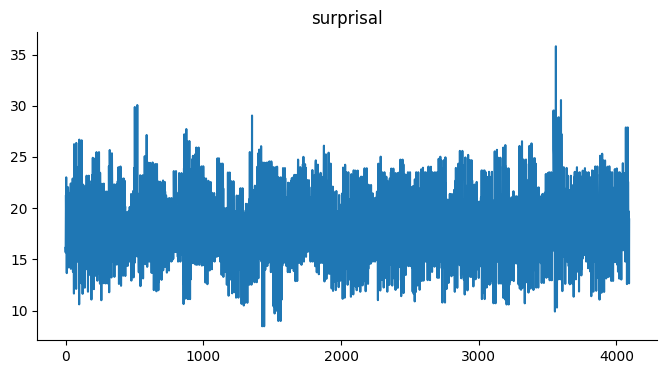

In [ ]:
# @title surprisal

from matplotlib import pyplot as plt
results['surprisal'].plot(kind='line', figsize=(8, 4), title='surprisal')
plt.gca().spines[['top', 'right']].set_visible(False)